In [1]:
import pandas as pd
import numpy as np
import h5py
import os
import datetime
import copy
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['axes.facecolor'] = 'w'

In [2]:
year, month, day = '2021', '10', '15'
start_date = pd.Timestamp(year + '.' + month.zfill(2) + '.' + day.zfill(2))
tmax = '30'
daysPlot = 30

#define scenarios
strings = ['']
#strings = ['_future_high_mask_test']
#define compartments
secir_dict = {0:'Susceptible', 1:'Partially Vaccinated', 2:'Exposed', 3:'ExposedV1', 4:'ExposedV2', 5:'Carrier',
              6:'CarrierV1',7:'CarrierV2', 8:'CarrierT', 9:'CarrierTV1', 10:'CarrierTV2', 11:'Infected',
              12:'InfectedV1',13:'InfectedV2', 14:'InfectedT', 15:'InfectedTV1', 16:'InfectedTV2',
              17:'Hospitalized', 18:'HospitalizedV1', 19:'HospitalizedV2', 20:'ICU',
              21:'ICUV1', 22:'ICUV2', 23:'Immune', 24:'Dead', 25: 'Infected Total'}
new_secir_dict = {0:'Susceptible', 1:'Partially Vaccinated', 2:'Exposed', 3:'Carrier', 4:'Infected',
              5:'Hospitalized', 6:'ICU', 7:'Immune', 8:'Dead', 9: 'Infected Total'}
concat_comps = {0:[0], 1:[1], 2:[2,3,4], 3:[5,6,7,8,9,10], 4:[11, 12, 13, 14, 15, 16],
            5:[17, 18, 19], 6:[20, 21, 22], 7:[23], 8:[24], 9:[25]}

#define age groups
age_groups = ['0-4 Years', '5-14 Years', '15-34 Years', '35-59 Years', '60-79 Years', '80+ Years']

### Plot parameters

In [3]:
# define colors for age groups
plt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
print(get_cmap(0))
colors = {}
colors['Total'] = plt_colors[0]
for i in range(len(age_groups)):
    colors['Group' + str(i+1)] = plt_colors[i]
    


In [4]:
# define population data for incidence values
base = 100000
age_group_sizes = np.array([3961376,7429883,19117865,28919134,18057318,5681135])

relative_dict = {}
for i in range(len(age_group_sizes)):
    relative_dict['Group' + str(i+1)] = age_group_sizes[i]/base
    
relative_dict['Total'] = np.sum(age_group_sizes)/base

    

In [5]:
plotRKI = False           # Plots RKI Data if true
plotRelative = False     # Plots incidence values if true
plotPercentiles = True  # Plots 25 and 75 percentiles if true
plotConfidence = False   # Plots 05 and 95 percentiles if true

In [6]:
savePlot = True          # saves plot file if true
if savePlot:
    try:
        os.mkdir('Plots')
    except:
        print('Directory "Plots" already exists')

Directory "Plots" already exists


In [7]:


opacity = 0.15           
lineWidth = 3.5
fontsize = 24
figsize = (8, 6)

#define x-ticks for plots
datelist = np.array(pd.date_range(start_date.date(), periods=daysPlot, freq='D').strftime('%m-%d').tolist())
tick_range = (np.arange(int(daysPlot / 10) + 1) * 10)
tick_range[-1] -= 1

In [8]:
scenario_label = {
    '': 'No commuter testing, local NPIs decreed until July 1st, no masks after opening' ,
    '_late': 'No commuter testing, local NPIs decreed until August 1st, no masks after opening' ,
    '_mask_test': 'Commuter testing, local NPIs decreed until July 1st, keeping masks and distancing', 
    '_late_mask_test': 'Commuter testing, local NPIs decreed until August 1st, keeping masks and distancing',
    '_long': 'No commuter testing, local NPIs decreed until July 1st, no masks after opening' ,
    '_long_late': 'No commuter testing, local NPIs decreed until August 1st, no masks after opening' ,
    '_long_mask_test': 'Commuter testing, local NPIs decreed until July 1st, keeping masks and distancing', 
    '_long_late_mask_test': 'Commuter testing, local NPIs decreed until August 1st, keeping masks and distancing',
    '_future_long': 'No commuter testing, no local NPIs' ,
    '_future_long_mask_test': 'No commuter testing, no local NPIs except for masks and distancing',  
    '_future': 'No commuter testing, no local NPIs' ,
    '_future_mask_test': 'No commuter testing, no local NPIs except for masks and distancing', 
    '_high': 'No commuter testing, local NPIs decreed until July 1st, no masks after opening' ,
    '_high_late': 'No commuter testing, local NPIs decreed until August 1st, no masks after opening' ,
    '_high_mask_test': 'Commuter testing, local NPIs decreed until July 1st, keeping masks and distancing', 
    '_high_late_mask_test': 'Commuter testing, local NPIs decreed until August 1st, keeping masks and distancing',
    '_long_high': 'No commuter testing, local NPIs decreed until July 1st, no masks after opening' ,
    '_long_high_late': 'No commuter testing, local NPIs decreed until August 1st, no masks after opening' ,
    '_long_high_mask_test': 'Commuter testing, local NPIs decreed until July 1st, keeping masks and distancing', 
    '_long_high_late_mask_test': 'Commuter testing, local NPIs decreed until August 1st, keeping masks and distancing',
    '_future_long_high': 'No commuter testing, no local NPIs' ,
    '_future_long_high_mask_test': 'No commuter testing, no local NPIs except for masks and distancing',  
    '_future_high': 'No commuter testing, no local NPIs' ,
    '_future_high_mask_test': 'No commuter testing, no local NPIs except for masks and distancing',
    '7_future_high_mask_test': 'S1: contact reduc. x%',
    '6_future_high_mask_test': 'S2: contact reduc. y%',
    '5_future_high_mask_test': 'S3: contact reduc. z%'
}

In [9]:
def plot_results(files, comp_idx, title, ylim=None, filename='', key='Total', plotLegend=True):
    fig, ax = plt.subplots(figsize=figsize)
        
    
    if plotRelative:
        factor = relative_dict[key]
    else:
        factor = 1

    X = np.arange(daysPlot)
        
    if plotRKI:
        ax.plot(X[:daysPlotRKI], d[key][:daysPlotRKI, comp_idx]/factor,'--', label='RKI',
            color='gray', linewidth=lineWidth)
        
    ax.plot(X, files['p50']['14'][key][:daysPlot, comp_idx]/factor, label='p50',
            color=colors[key], linewidth=lineWidth)
    if plotPercentiles:    
        ax.plot(X, files['p25']['14'][key][:daysPlot, comp_idx]/factor,'--', label='p25',
                color=colors[key], linewidth=lineWidth)
        ax.plot(X, files['p75']['14'][key][:daysPlot, comp_idx]/factor,'--',  label='p75',
                color=colors[key], linewidth=lineWidth)
        ax.fill_between(X, files['p25']['14'][key][:daysPlot, comp_idx]/factor,
                        files['p75']['14'][key][:daysPlot, comp_idx]/factor,
                        color=colors[key], alpha=opacity) 
    if plotConfidence:    
        ax.plot(X, files['p05']['14'][key][:daysPlot, comp_idx]/factor,'--', label='p05',
                color=colors[key], linewidth=lineWidth)
        ax.plot(X, files['p95']['14'][key][:daysPlot, comp_idx]/factor,'--',  label='p95',
                color=colors[key], linewidth=lineWidth)
        ax.fill_between(X, files['p05']['14'][key][:daysPlot, comp_idx]/factor, 
                        files['p95']['14'][key][:daysPlot, comp_idx]/factor,
                        color=colors[key], alpha=opacity) 
        
    if plotRKI:
        ax.plot(X[:daysPlotRKI], d[key][:daysPlotRKI, comp_idx]/factor,'--',
            color='gray', linewidth=lineWidth)
        

    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks(tick_range)
    ax.set_xticklabels(datelist[tick_range], rotation=45, fontsize=fontsize)
    if plotRelative:
        ax.set_ylabel('individuals relative per 100.000', fontsize=fontsize)
    else:
        ax.set_ylabel('number of individuals', fontsize=fontsize)
    if plotLegend:
        ax.legend(fontsize=fontsize, loc='upper left')
    plt.yticks(fontsize=fontsize)
    ax.grid(linestyle='dotted')

    if str(ylim) != 'None':
        if '_high' in filename:
            print(filename.replace('_high', ''))
            print(ax.get_ylim()[1])
            ylim[filename.replace('_high', '')] = ax.get_ylim()[1]
        else:
            ax.set_ylim(top=ylim[filename])

    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
    ax.yaxis.offsetText.set_fontsize(fontsize)

    fig.tight_layout()
    
    if savePlot:
        if plotRKI:
            fig.savefig('Plots/RKI_' + title.replace(' ', '_') + filename + '.png')
        else:
            fig.savefig('Plots/' + title.replace(' ', '_') + filename + '.png')

    return ylim


In [10]:
def plot_all_results(all_files, comp_idx, title, filename = '', key='Total', show_perc=False):
    fig, ax = plt.subplots(figsize=figsize)
        
    fs = 16
    
    for scenario, color in zip(all_files, list(colors.values())[1:]):
        files = all_files[scenario]
        if plotRelative:
            factor = relative_dict[key]
        else:
            factor = 1
            
        X = np.arange(daysPlot)
        
        ax.plot(X, files['p50']['14'][key][:daysPlot, comp_idx]/factor, label= scenario_label[scenario],
                color=color,linewidth=lineWidth)

        if show_perc:    
            ax.plot(X, files['p25']['14'][key][:daysPlot, comp_idx]/factor,'--',
                    color=color, linewidth=lineWidth)
            ax.plot(X, files['p75']['14'][key][:daysPlot, comp_idx]/factor,'--',
                    color=color, linewidth=lineWidth)
            ax.fill_between(X, files['p25']['14'][key][:daysPlot, comp_idx]/factor,
                            files['p75']['14'][key][:daysPlot, comp_idx]/factor,
                            color=color, alpha=opacity) 
            
    if plotRKI:
        ax.plot(X[:daysPlotRKI], rki_df[key][:daysPlotRKI, comp_idx]/factor,'--', label='RKI',
            color='gray', linewidth=lineWidth)
        

    ax.set_title(title, fontsize=fs)
    ax.set_xticks(tick_range)
    ax.set_xticklabels(datelist[tick_range], rotation=45, fontsize=fs)
    if plotRelative:
        ax.set_ylabel('individuals relative per 100.000', fontsize=fs)
    else:
        ax.set_ylabel('number of individuals', fontsize=fs)
    ax.legend(fontsize=10)
    plt.yticks(fontsize=fs)
    ax.grid(linestyle='dotted')
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
    ax.yaxis.offsetText.set_fontsize(fs)
    
    fig.tight_layout()
    
    if savePlot:
        fig.savefig('Plots/' + title.replace(' ', '_') + filename + '.png')


In [11]:
vacc_df_backup = pd.read_json('../cpp/input/data/pydata/Germany/all_county_agevacc_vacc_ma7.json')
vacc_df_backup

,Date,ID_County,Age_RKI,Vacc_partially,Vacc_completed,Vacc_refreshed
0,2020-12-27,1001,12-17,0.000000,0.000000,0.000000
1,2020-12-28,1001,12-17,0.000000,0.000000,0.000000
2,2020-12-29,1001,12-17,0.000000,0.000000,0.000000
3,2020-12-30,1001,12-17,0.000000,0.000000,0.000000
4,2020-12-31,1001,12-17,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
405595,2021-11-25,16077,60+,27275.488865,28959.139318,7263.252811
405596,2021-11-26,16077,60+,27291.945680,28969.172759,7522.958690
405597,2021-11-27,16077,60+,27317.063613,28986.383918,7783.569969
405598,2021-11-28,16077,60+,27323.085139,28986.401273,7912.392372


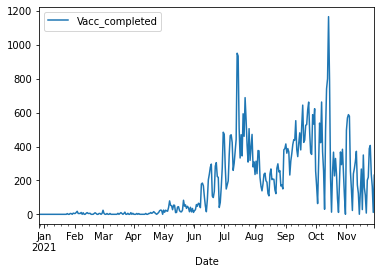

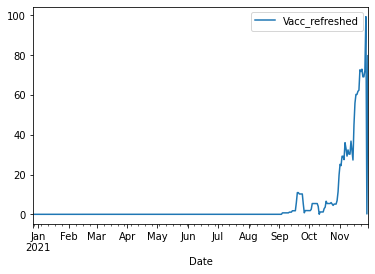

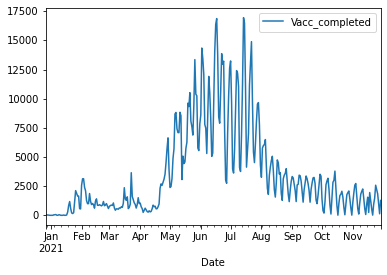

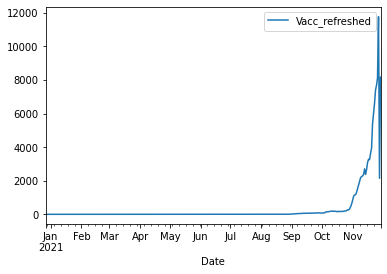

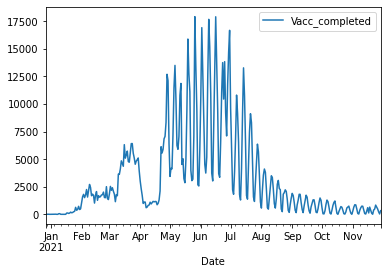

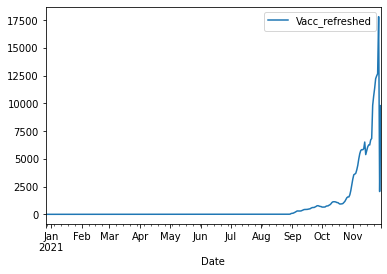

In [12]:
vacc_df = vacc_df_backup.copy()
vacc_df = vacc_df[(vacc_df.ID_County >= 14000) & (vacc_df.ID_County < 15000)].groupby(['Date', 'Age_RKI'], as_index=False).sum()
vacc_df = vacc_df.drop('ID_County', axis = 1)
for col in ['Vacc_completed', 'Vacc_refreshed']:
    vacc_df[col] = vacc_df.groupby(['Age_RKI'])[col].diff()

vacc_df = vacc_df.set_index('Date')
for age in ['12-17', '18-59', '60+']:
    for col in ['Vacc_completed', 'Vacc_refreshed']:
        plt.figure()
        vacc_df[vacc_df.Age_RKI == age][col].plot(legend=True)

In [13]:
#reduce rki json file
import pandas.io.json
df = pd.read_json('../cpp/input/data/pydata/Germany/all_county_age_ma7_rki.json')
df = df[df.Date.dt.date >= datetime.date(2021, 9, 1)]

df.Date = df.Date.dt.strftime('%Y-%m-%d')
pandas.io.json.to_json('../cpp/input/data/pydata/Germany/all_county_age_ma7_rki.json.new', df, orient = 'records')

In [14]:
def open_files(iter = ''):
    # load files
    files = {}

    for scenario in strings:
        files[scenario] = {}

        path = '../cpp/output' + iter + scenario

        files[scenario]['p50'] = h5py.File(path + '/p50/Results.h5', 'r+')

        files[scenario]['p25'] = h5py.File(path + '/p25/Results.h5', 'r+')
        files[scenario]['p75'] = h5py.File(path + '/p75/Results.h5', 'r+')

        files[scenario]['p05'] = h5py.File(path + '/p05/Results.h5', 'r+')
        files[scenario]['p95'] = h5py.File(path + '/p95/Results.h5', 'r+')

        if plotRKI:
            files[scenario]['RKI'] = h5py.File('../cpp/output/Results_rki.h5', 'r+')
            # if month == '6':
            #     files[scenario]['RKI'] = h5py.File('../cpp/output/Results_rki.h5', 'r+')
            # elif month == '10':
            #     files[scenario]['RKI'] = h5py.File('../cpp/output/Results_rki_future.h5', 'r+')

    
    return files

def close_files(files):
    for group in files:
        for file in files[group]:
            files[group][file].close()



In [15]:
def concat_comparts(files, comparts):
    new_files = {}
    for scenario in strings:
        print(scenario)
        new_files[scenario] = {}
        percentile_list = ['p50', 'p25','p75','p05','p95']
        if plotRKI:
            percentile_list += ['RKI']
        for p in percentile_list:
            new_files[scenario][p] = {'14':{}}
            for key in ['Group' + str(group+1) for group in range(6)] + ['Total']:
                if p == 'RKI':
                    new_files[scenario][p]['14'][key] = np.zeros((len(files[scenario][p]['14521']['Time']), len(comparts)))
                    for i in range(1000):
                        county_id = 14000 + i
                        if str(county_id) not in files[scenario][p]:
                            continue
                        for new_comp in range(len(comparts)):
                            for old_comp in comparts[new_comp]:
                                new_files[scenario][p]['14'][key][:, new_comp] += files[scenario][p][str(county_id)][key][:, old_comp]
                else:
                    new_files[scenario][p]['14'][key] = np.zeros((len(files[scenario][p]['14']['Time']), len(comparts)))
                    for new_comp in range(len(comparts)):
                        for old_comp in comparts[new_comp]:
                            new_files[scenario][p]['14'][key][:, new_comp] += files[scenario][p]['14'][key][:, old_comp]


                        
    return new_files

In [42]:
rki_df_backup = pd.read_json('../cpp/input/data/pydata/Germany/all_county_age_rki.json')

In [39]:
year, month, day = '2021', '10', '15'
start_date = pd.Timestamp(year + '.' + month.zfill(2) + '.' + day.zfill(2))
tmax = '70'
daysPlot = 70
daysPlotRKI = 47

C:\Users\abel_da\AppData\Local\Temp/ipykernel_14324/2217572926.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d[key][t, 4] = rki_df_t[(rki_df.Age_RKI == key_map[key])].ConfirmedNew.sum()


Age_RKI
A00-A04    AxesSubplot(0.125,0.125;0.775x0.755)
A05-A14    AxesSubplot(0.125,0.125;0.775x0.755)
A15-A34    AxesSubplot(0.125,0.125;0.775x0.755)
A35-A59    AxesSubplot(0.125,0.125;0.775x0.755)
A60-A79    AxesSubplot(0.125,0.125;0.775x0.755)
A80+       AxesSubplot(0.125,0.125;0.775x0.755)
Name: ConfirmedNew, dtype: object

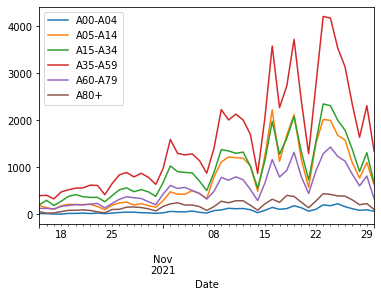

In [43]:
end_date = start_date.date() + datetime.timedelta(days = daysPlotRKI)
rki_df = rki_df_backup.copy()
rki_df = rki_df[
    (rki_df.ID_County >= 14000) & (rki_df.ID_County < 15000) & 
    (rki_df.Age_RKI != "unknown") &
    (rki_df.Date.dt.date >= start_date.date() - datetime.timedelta(days = 1)) & (rki_df.Date.dt.date <= end_date)]
rki_df = rki_df.sort_values(by = 'Date')
rki_df['ConfirmedNew'] = rki_df.groupby(['ID_County', 'Age_RKI']).Confirmed.diff() #de-aggregate
rki_df = rki_df[rki_df.Date.dt.date >= start_date.date()]
rki_df = rki_df[['Date', 'Age_RKI', 'ConfirmedNew']].groupby(['Date','Age_RKI'], as_index = False).sum() #sum over counties
d = dict()
for key in [*['Group' + str(i + 1) for i in range(6)], 'Total']:
    d[key] = np.zeros((daysPlotRKI, 10))
    key_map = {'Group1' : 'A00-A04', 'Group2' : 'A05-A14', 'Group3': 'A15-A34', 'Group4' : 'A35-A59', 'Group5' : 'A60-A79', 'Group6' : 'A80+'}
    for t in range(daysPlotRKI):
        rki_df_t = rki_df[(rki_df.Date.dt.date == start_date.date() + datetime.timedelta(days = t))]
        if (key == 'Total'):
            d[key][t, 4] = rki_df_t.ConfirmedNew.sum()
        else:
            d[key][t, 4] = rki_df_t[(rki_df.Age_RKI == key_map[key])].ConfirmedNew.sum()

#plot
rki_df = rki_df.set_index('Date')
rki_df.groupby(['Age_RKI']).ConfirmedNew.plot(legend=True)

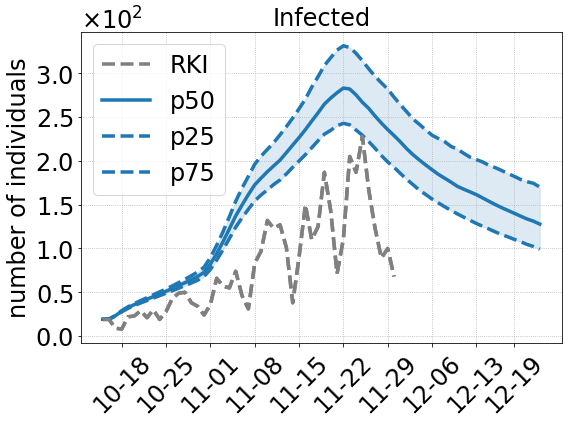

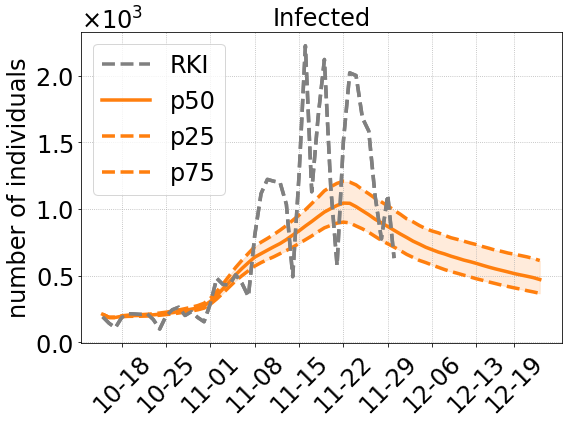

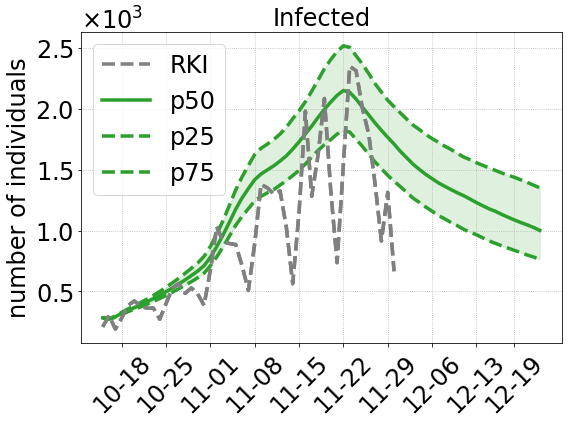

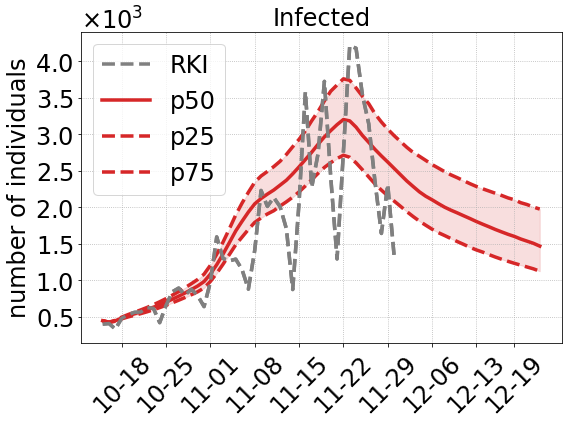

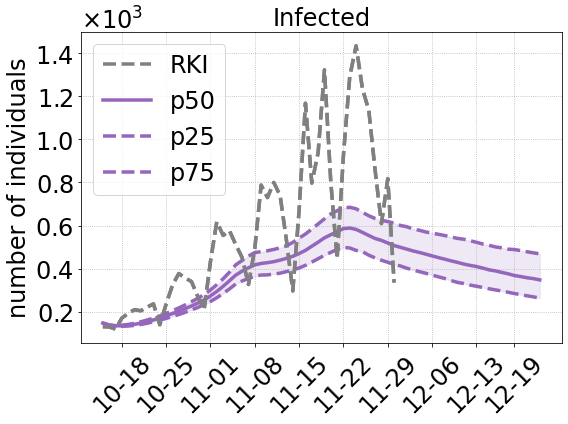

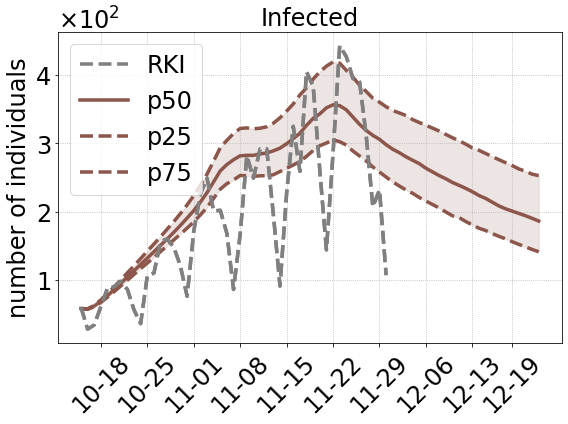

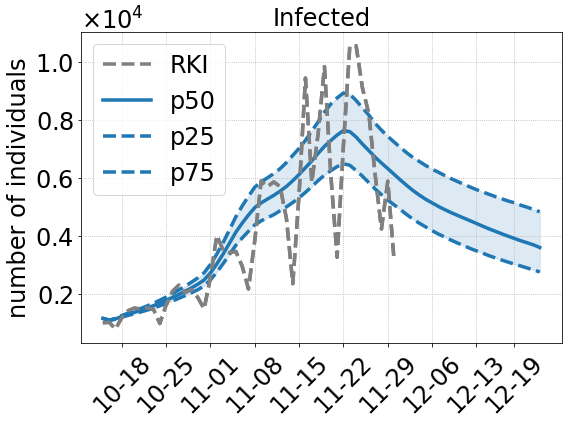

In [46]:
datelist = np.array(pd.date_range(start_date.date(), periods=daysPlot, freq='D').strftime('%m-%d').tolist())
# tick_range = (np.arange(int(daysPlot / 7) + 1) * 7)
tick_range = np.arange(3, daysPlot, 7)
tick_range[-1] -= 1
plotRKI=True
ylim = {}
# comparts = [4, 6, 8]
comparts = [4]
for compart in comparts:
    for high in ['']:
        strings = [high + '']
        
        files = open_files('')
        new_files = concat_comparts(files, concat_comps)
        
        # plot_all_results(new_files, compart, new_secir_dict[compart], filename=high + '_all', key='Group2')
        scenario = ''
        for key in [*['Group' + str(i + 1) for i in range(6)], 'Total']:
            ylim = plot_results(new_files[scenario], compart, new_secir_dict[compart], None, filename=scenario, key=key)
            dummy = 1
        close_files(files)
            


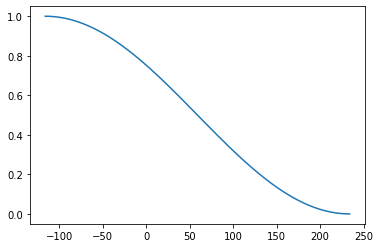

In [17]:
x = np.linspace(-116, -116 + 350, 100)
f = lambda x: (np.cos((x + 116) / 350 * np.pi) + 1) / 2
plt.plot(x, f(x))

In [ ]:
year, month, day = '2021', '10', '15'
start_date = pd.Timestamp(year + '.' + month.zfill(2) + '.' + day.zfill(2))
tmax = '90'
daysPlot = 91

datelist = np.array(pd.date_range(start_date.date(), periods=daysPlot, freq='D').strftime('%m-%d').tolist())
tick_range = (np.arange(int(daysPlot / 10) + 1) * 10)
tick_range[-1] -= 1
plotRKI=True
plotPercentiles = True
ylim = {}
comparts = [4]
for compart in comparts:
    for high in ['_high']:
        strings = ['7_future' + high + '_mask_test', '6_future' + high + '_mask_test','5_future' + high + '_mask_test']
        
        files = open_files('_new_final')
        new_files = concat_comparts(files, concat_comps)
        plot_all_results(new_files, compart, new_secir_dict[compart], filename=high + '_all', key='Total', show_perc=True)
        for scenario in strings:
            ylim = plot_results(new_files[scenario], compart, new_secir_dict[compart], ylim, filename=scenario, key='Total')
            dummy = 1
        close_files(files)
        

In [ ]:
def plot_bars(show_perc, name, files, columns, rows, lim = 100, rel=False, compart =9):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_rows = len(rows)
    num_groups = 6
    bar_width = 1/len(files)
    index = np.arange(n_rows)*bar_width
    scen_width = 8/len(files)

    keys = list(files.keys())


    cell_text = []
    fig, ax = plt.subplots(figsize=(20,10))
    #ax = fig.add_axes([0,0,1,1])
    for i in range(n_rows):
        key = 'Group' + str(i+1)
        for j in range(len(files)):
            factor = relative_dict[key]
            ax.bar(index[i] + j*scen_width, (files[keys[j]]['p50']['0'][key][-1,compart] - files[keys[j]]['p50']['0'][key][0,compart])/factor, color = color[i], width =bar_width, edgecolor='black')
            if show_perc and not (j==0 or j == 4):
                ax.bar(index[i] + j*scen_width, (files[keys[j]]['p75']['0'][key][-1,compart] - files[keys[j]]['p75']['0'][key][0,compart])/factor, color = color[i], width =bar_width, edgecolor='black', alpha=0.6)
                
        cell_text.append(['%1.1f' % ((files[keys[x]]['p50']['0'][key][-1,compart] - files[keys[x]]['p50']['0'][key][0,compart])/factor ) for x in range(len(files))])
        

    if len(files) == 8:
        ax.set_xlim(-0.2,7.8)
    else:
        ax.set_xlim(-0.5,7.5)
    '''_, top = ax.get_ylim()
    if top > lim:
        ax.set_ylim(top=lim)'''
        
    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=color,
                          colLabels=columns,
                          fontsize=30, 
                          loc='bottom',
                          cellLoc = 'center')
    the_table.auto_set_font_size(False)
    the_table.scale(1,2)
    the_table.set_fontsize(18)
    # Adjust layout to make room for the table:
    #plt.subplots_adjust(left=0.2, bottom=0.8)

    if rel:
        ax.set_ylabel('age distributed infections [%]', fontsize=20)
        plt.title('Age distributed ratios of infected on September 3', fontsize=20)
    else:
        ax.set_ylabel('individuals relative per 100.000', fontsize=20)
        plt.title('Cumulative number of infections per 100.000', fontsize=20)
    #plt.yticks(values * value_increment, ['%d' % val for val in values])
    plt.xticks([])
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(name + '.png')

In [ ]:
strings = ['',  '_late', '_mask_test', '_late_mask_test', '_high',  '_high_late', '_high_mask_test', '_high_late_mask_test']
files = open_files('_new_final4')
new_files = concat_comparts(files, concat_comps)

columns = ('S1 - 40%', 'S2 - 40%', 'S3 - 40%', 'S4 - 40%', 'S1 - 60%', 'S2 - 60%', 'S3 - 60%', 'S4 - 60%')
rows =  ['0-4 Years', '5-14 Years', '15-34 Years', '35-59 Years', '60-79 Years', '80+ Years']

plot_bars(True, 'age_incidence', new_files, columns, rows, 200)
close_files(files)

In [ ]:
strings = ['7_future_high_mask_test', '6_future_high_mask_test', '5_future_high_mask_test']
files = open_files('_new_final')
new_files = concat_comparts(files, concat_comps)


columns = ('S1: contact reduc. x%', 'S2: contact reduc. y%', 'S3: contact reduc. z%')
rows =  ['0-4 Years', '5-14 Years', '15-34 Years', '35-59 Years', '60-79 Years', '80+ Years']

plot_bars(False, 'age_incidence', new_files, columns, rows, 200)
close_files(files)

In [ ]:
year, month, day = '2021', '6', '6'
start_date = pd.Timestamp(year + '.' + month.zfill(2) + '.' + day.zfill(2))
tmax = '90'
daysPlot = 91

datelist = np.array(pd.date_range(start_date.date(), periods=daysPlot, freq='D').strftime('%m-%d').tolist())
tick_range = (np.arange(int(daysPlot / 10) + 1) * 10)
tick_range[-1] -= 1
plotRKI=False
plotPercentiles = False
savePlot = True
ylim = {}
comparts = [1, 2, 4,7, 9]
strings = ['_high_mask_test']

files = open_files('_new_final4')
new_files = concat_comparts(files, concat_comps)
new_files[strings[0]]['p50']['0']['Total'][:,7] -= new_files[strings[0]]['p50']['0']['Total'][:,9]
temp_secir_dict = {
    1: 'Partially Vaccinated',
    2: 'Exposed',
    4: 'Infected',
    7: 'Fully Vaccinated',
    9: 'Cumulative number of Infections'
}
for compart in comparts:
    
    for scenario in strings:
        plot_results(new_files[scenario], compart, temp_secir_dict[compart], None, filename='vacc' + scenario, key='Total', plotLegend=False)
        
    close_files(files)